In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from utils import get_data

results_df = None

from sklearn.preprocessing import MinMaxScaler

def plot_model(test_data, predictions, p, q, title='Model Estimation'):
    # Normalizing count and d_ln_avg_efficiency
    scaler = MinMaxScaler(feature_range=(-0.15, 0.15))
    normalized_values = scaler.fit_transform(test_data[['count', 'd_ln_avg_efficiency', 'cost', 'open_price']])
    normalized_count = normalized_values[:, 0]
    normalized_d_ln_avg_efficiency = normalized_values[:, 1]
    normalized_cost = normalized_values[:, 2]
    normalized_open_price = normalized_values[:, 3]
    
    # Plotting the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data.index, test_data['d_ln_open_price'], label='Actual d_ln_open_price', color='blue', marker='o')
    plt.scatter(test_data.index, predictions, label='Predicted d_ln_open_price', color='red', marker='x')
    plt.plot(test_data.index, normalized_count, label='Normalized Count', color='green', linestyle='--')
    # plt.plot(test_data.index, normalized_d_ln_avg_efficiency, label='Normalized d_ln_avg_efficiency', color='purple', linestyle='-.')
    plt.plot(test_data.index, normalized_cost, label='Normalized Cost', color='orange', linestyle=':')
    plt.plot(test_data.index, normalized_open_price, label='Normalized Open Price', color='black', linestyle='-.')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
    plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
    plt.xlabel('Date')
    plt.ylabel('diff of ln(open price) and Normalized Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

def add_constant(train_exog, test_exog):
    # train_exog["const"] = 1
    # test_exog["const"] = 1
    # # Ensure the shapes of train_exog and test_exog match
    # print(train_exog.columns)
    # print(test_exog.columns)
    return train_exog, test_exog

def get_stats(model_fit, predictions, test_data):
    mae = mean_absolute_error(test_data['d_ln_open_price'], predictions)
    mse = mean_squared_error(test_data['d_ln_open_price'], predictions)
    rmse = np.sqrt(mse)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Test residuals for autocorrelation, normality, and heteroscedasticity
    residuals = model_fit.resid
    # Autocorrelation tests
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    durbin_watson = sm.stats.durbin_watson(residuals)
    # Normality tests
    jarque_bera = sm.stats.jarque_bera(residuals)
    shapiro_wilk = shapiro(residuals)
    # Heteroscedasticity test
    white_test = [-1,-1]
    try:
        white_test = sm.stats.het_white(residuals, model_fit.model.exog)
    except Exception as e:
        pass
    
    return {
        'MAE':mae,
        'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'BIC': bic,
        'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
        'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
        'White Test': white_test[1]
    }

# Adjust the model estimation to use the differenced series
def model_estimation(data, p_range, q_range, title='Model Estimation', eval_size=8):
    global results_df
    
    # Baseline 3: no exog
    use_exog = False
    # use_exog = True

    results = []
    data_size = len(data)
    train_size = data_size - eval_size

    cols = ['cost','d_cost']  #,'d_ln_avg_efficiency', 'count' ,'time']

    for p in p_range:
        for q in q_range:
            try:
                # Perform rolling cross-validation
                rolling_mae = []
                rolling_mse = []
                mean_baseline_mae = []
                mean_baseline_mse = []
                prev_value_baseline_mae = []
                prev_value_baseline_mse = []
                step_size = 1
                for end in range(train_size, data_size, step_size):  # Adjust these values as needed
                    print(f"p: {p}, q: {q}, end: {end}")
                    rolling_train = data.iloc[0:end]
                    rolling_test = data.iloc[end:end + step_size]  # Predict one step ahead
                    rolling_train_exog, rolling_test_exog = add_constant(rolling_train[cols], rolling_test[cols])
                    
                    # Baseline 1: Mean Prediction
                    mean_pred = np.mean(rolling_train['d_ln_open_price'])
                    mean_baseline_mae.append(mean_absolute_error(rolling_test['d_ln_open_price'], [mean_pred]*step_size))
                    mean_baseline_mse.append(mean_squared_error(rolling_test['d_ln_open_price'], [mean_pred]*step_size))
                    
                    # Baseline 2: Previous Value Prediction
                    prev_value_pred = rolling_train['d_ln_open_price'].iloc[-1]
                    prev_value_baseline_mae.append(mean_absolute_error(rolling_test['d_ln_open_price'], [prev_value_pred]*step_size))
                    prev_value_baseline_mse.append(mean_squared_error(rolling_test['d_ln_open_price'], [prev_value_pred]*step_size))


                    # ARIMA Model
                    if use_exog:
                        model = ARIMA(rolling_train['d_ln_open_price'], order=(p, 0, q), exog=rolling_train_exog)
                    else:
                        model = ARIMA(rolling_train['d_ln_open_price'], order=(p, 0, q))
                    model_fit = model.fit()
                    if p == 1 and q == 1 and end == train_size:
                        print(model_fit.summary())
                    if use_exog:
                        predictions = model_fit.forecast(steps=step_size, exog=rolling_test_exog)
                    else:
                        predictions = model_fit.forecast(steps=step_size)
                    mae = mean_absolute_error(rolling_test['d_ln_open_price'], predictions)
                    mse = mean_squared_error(rolling_test['d_ln_open_price'], predictions)
                    rolling_mae.append(mae)
                    rolling_mse.append(mse)
                
                print("rolling_mse")
                print(rolling_mse)
                avg_mae = np.mean(rolling_mae)
                avg_mse = np.mean(rolling_mse)
                avg_mean_baseline_mae = np.mean(mean_baseline_mae)
                avg_mean_baseline_mse = np.mean(mean_baseline_mse)
                avg_prev_value_baseline_mae = np.mean(prev_value_baseline_mae)
                avg_prev_value_baseline_mse = np.mean(prev_value_baseline_mse)
                results.append({'p': p, 'q': q, 'MAE': avg_mae, 'Mean Baseline MAE': avg_mean_baseline_mae, 'Prev Value Baseline MAE': avg_prev_value_baseline_mae, 'MSE': avg_mse, 'Mean Baseline MSE': avg_mean_baseline_mse, 'Prev Value Baseline MSE': avg_prev_value_baseline_mse})

            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")

    # sort results and print/plot only the top 3
    results = sorted(results, key=lambda x: x['MSE'])
    print(f"Mean Baseline MSE: {results[0]['Mean Baseline MSE']}")
    print(f"Previous Value Baseline MSE: {results[0]['Prev Value Baseline MSE']}")
    for i in range(3):
        p = results[i]['p']
        q = results[i]['q']
        print(f"Top {i+1} Model: ARIMA({p},0,{q}), MSE: {results[i]['MSE']}")
        # Fit the model on the entire training dataset
        train_data = data.iloc[0:train_size]
        test_data = data.iloc[train_size:]
        if use_exog:
            train_exog, test_exog = add_constant(train_data[cols], test_data[cols])
            model = ARIMA(train_data['d_ln_open_price'], order=(p, 0, q), exog=train_exog)
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)
        else:
            model = ARIMA(train_data['d_ln_open_price'], order=(p, 0, q))
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test_data))
        print(get_stats(model_fit, predictions, test_data))
        plot_model(test_data, predictions, p, q, title=f"{title} - Top {i+1} Model")



In [90]:

def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    cols = ['d_ln_open_price','cost'] #'d_ln_avg_efficiency', 
    numeric_df = df[cols]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # print(summary)

    for col in cols:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=10, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=10, ax=axes[1])
            plt.show()

    return summary


def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    # if result[1] > 0.05:
    #     print("Series is not stationary")
    # else:
    #     print("Series is stationary")


from statsmodels.tsa.stattools import coint
def perform_cointegration_test(df, column1, column2):
    """
    Perform the co-integration test on two specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: The name of the first column to test.
    - column2: The name of the second column to test.

    Returns:
    - coint_t: The t-statistic of the test.
    - p_value: The p-value of the test.
    - crit_value: Critical values for the test.
    """
    score, p_value, crit_value = coint(df[column1], df[column2])
    print(f"Co-integration test results for {column1} and {column2}:")
    print(f"t-statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical values: {crit_value}")
    if p_value < 0.05:
        print("The series are likely co-integrated.")
    else:
        print("The series are not likely co-integrated.")
    # return score, p_value, crit_value


In [91]:
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2015-01-01', '9999-01-01')

In [92]:
# monthly_data[["cost"]].sample(10)

# Quaterly

Quarterly Data Model Estimation:
p: 1, q: 1, end: 22
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                   22
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  -4.297
Date:                Sun, 24 Mar 2024   AIC                             16.595
Time:                        22:07:01   BIC                             20.959
Sample:                    03-31-2015   HQIC                            17.623
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1491      0.128      1.167      0.243      -0.101       0.400
ar.L1         -0.0502      0.401     -0.125      0.900      -0.836       0.736

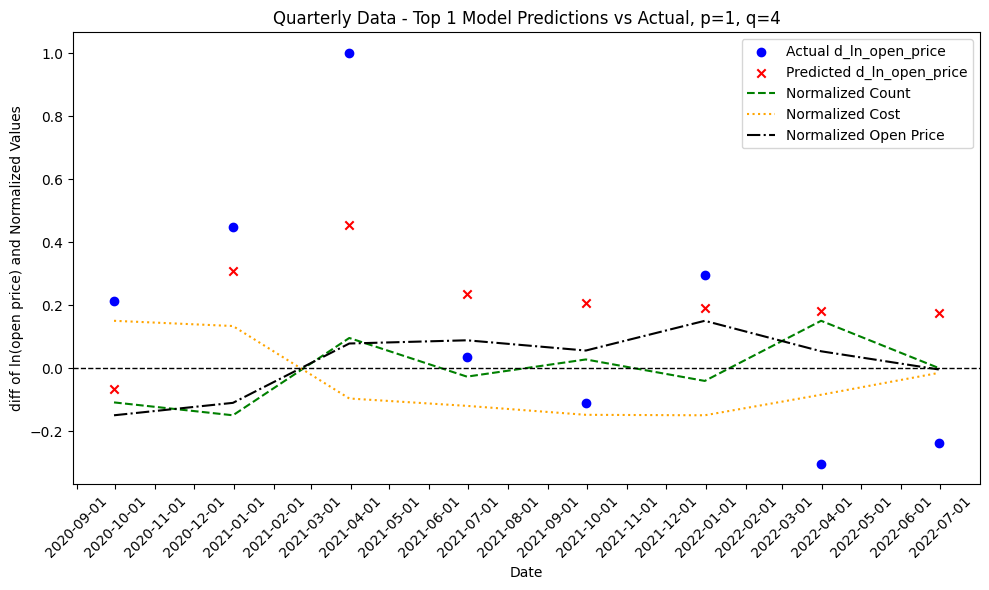

Top 2 Model: ARIMA(2,0,4), MSE: 0.10116416314615403
{'MAE': 0.2743201005984752, 'MSE': 0.09669151361104104, 'RMSE': 0.31095259061638486, 'AIC': 18.55296335663721, 'BIC': 27.28130298350374, 'Ljung-Box': 0.4363539466889247, 'Durbin-Watson': 1.8350736207273524, 'Jarque-Bera': 0.22352074534690566, 'Shapiro-Wilk': 0.5089563131332397, 'White Test': -1}


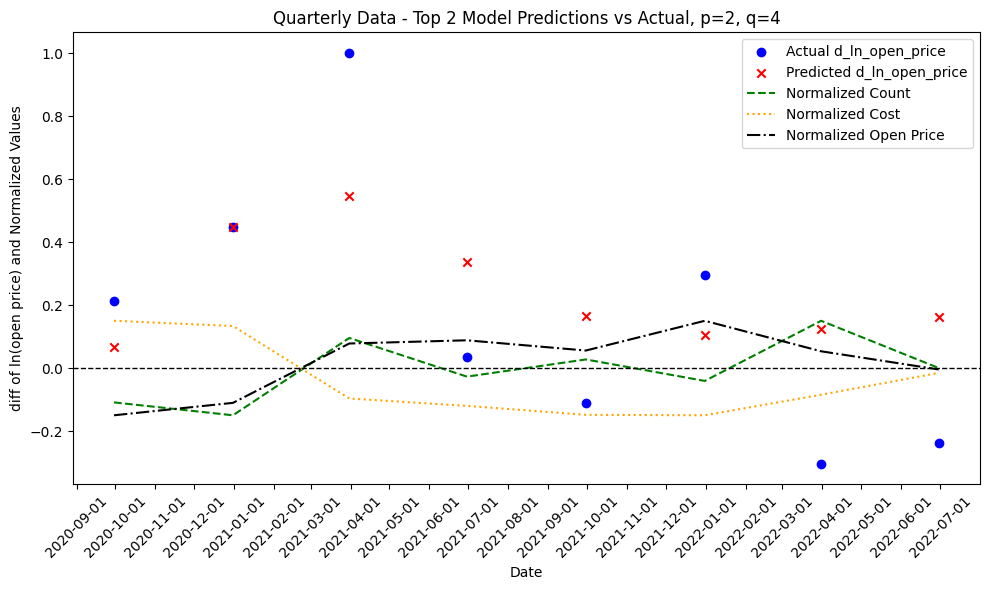

Top 3 Model: ARIMA(4,0,4), MSE: 0.11434547293667986
{'MAE': 0.2937052203864322, 'MSE': 0.12206288420523333, 'RMSE': 0.3493749908124984, 'AIC': 17.59013335152884, 'BIC': 28.500557885112002, 'Ljung-Box': 0.7645596577037035, 'Durbin-Watson': 2.0694996070105898, 'Jarque-Bera': 0.13925123478660928, 'Shapiro-Wilk': 0.10183876752853394, 'White Test': -1}


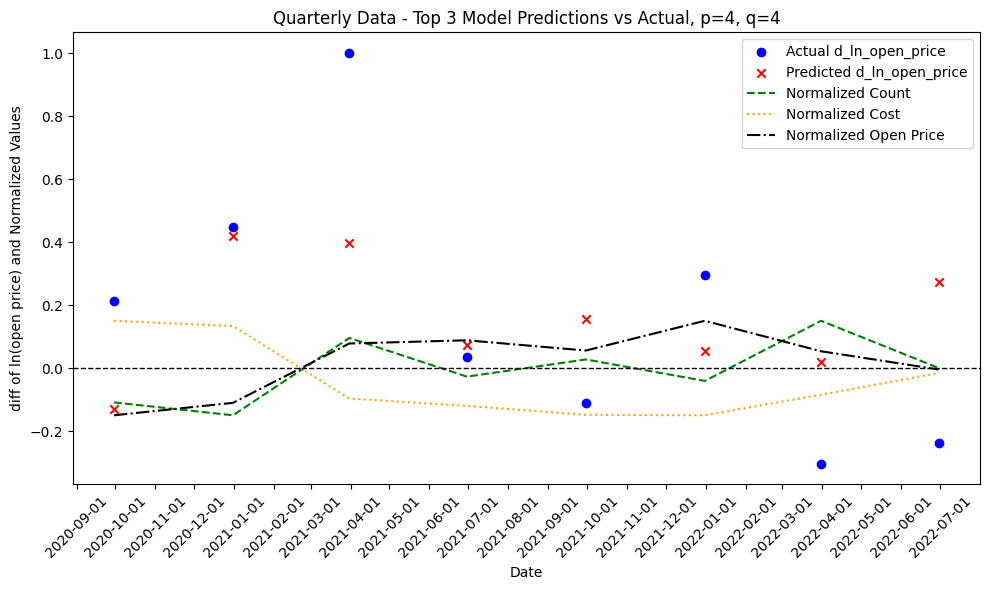

In [93]:
print("Quarterly Data Model Estimation:")
model_estimation(quarterly_data, range(1, 5, 1), range(1, 5, 1), title='Quarterly Data', eval_size=8)
results_df

In [42]:
print("Stationarity check for d_ln_open_price:")
check_stationarity(quarterly_data['d_ln_open_price'])
print("\nStationarity check for d_ln_avg_efficiency:")
check_stationarity(quarterly_data['d_ln_avg_efficiency'])
print("\nStationarity check for cost:")
check_stationarity(quarterly_data['cost'])
print("\nStationarity check for d_cost:")
check_stationarity(quarterly_data['d_cost'])
print("\nStationarity check for open_price:")
check_stationarity(quarterly_data['open_price'])

Stationarity check for d_ln_open_price:
ADF Statistic: -2.645562
p-value: 0.083941

Stationarity check for d_ln_avg_efficiency:
ADF Statistic: -7.688381
p-value: 0.000000

Stationarity check for cost:
ADF Statistic: -2.439210
p-value: 0.130974

Stationarity check for d_cost:
ADF Statistic: -0.345909
p-value: 0.918746

Stationarity check for open_price:
ADF Statistic: 1.442451
p-value: 0.997299


Distribution Plot:


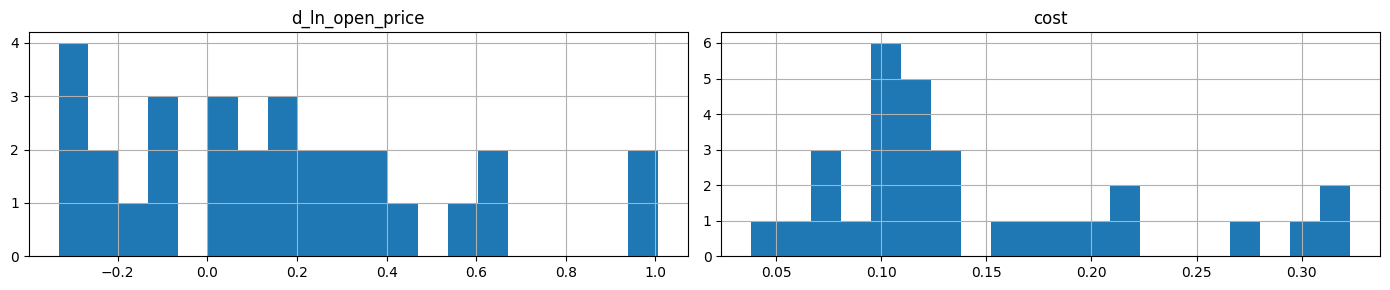

Summary Statistics:
ACF and PACF Plots for d_ln_open_price:


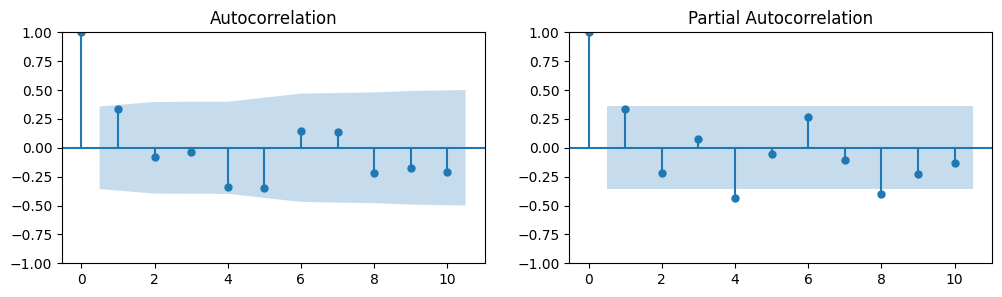

ACF and PACF Plots for cost:


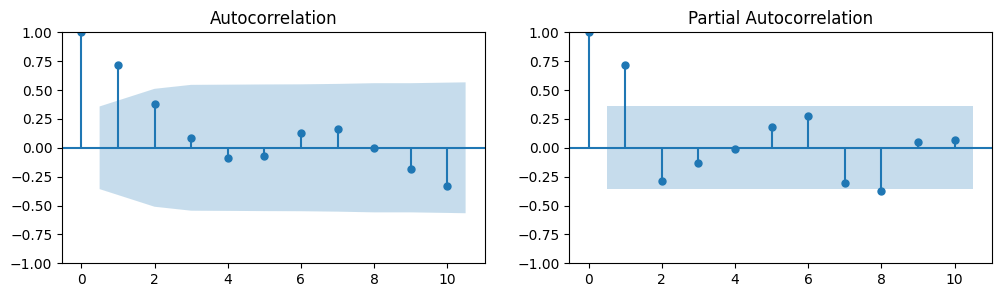

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_open_price,30.0,0.159283,0.359990,-0.332132,-0.102612,0.147316,0.339961,1.004616,0.723215,0.219692
cost,30.0,0.145470,0.076535,0.038107,0.099135,0.120222,0.181161,0.322974,1.063718,0.302065


In [49]:
exploratory_analysis(quarterly_data)

In [44]:
perform_cointegration_test(quarterly_data, 'd_ln_open_price', 'd_ln_avg_efficiency')

Co-integration test results for d_ln_open_price and d_ln_avg_efficiency:
t-statistic: -3.433109001175491
p-value: 0.038803893678177444
Critical values: [-4.31395736 -3.55493606 -3.19393252]
The series are likely co-integrated.


In [45]:
perform_cointegration_test(quarterly_data, 'd_ln_open_price', 'd_cost')

Co-integration test results for d_ln_open_price and d_cost:
t-statistic: -3.547029091415973
p-value: 0.028447925524964876
Critical values: [-4.31395736 -3.55493606 -3.19393252]
The series are likely co-integrated.


# Monthly

Monthly Data Model Estimation:
p: 1, q: 1, end: 78
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                   78
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  42.375
Date:                Sun, 24 Mar 2024   AIC                            -72.750
Time:                        20:58:36   BIC                            -58.609
Sample:                    01-31-2015   HQIC                           -67.089
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0734      0.038      1.939      0.052      -0.001       0.148
cost          -0.0803      0.197     -0.408      0.683      -0.466       0.306
d

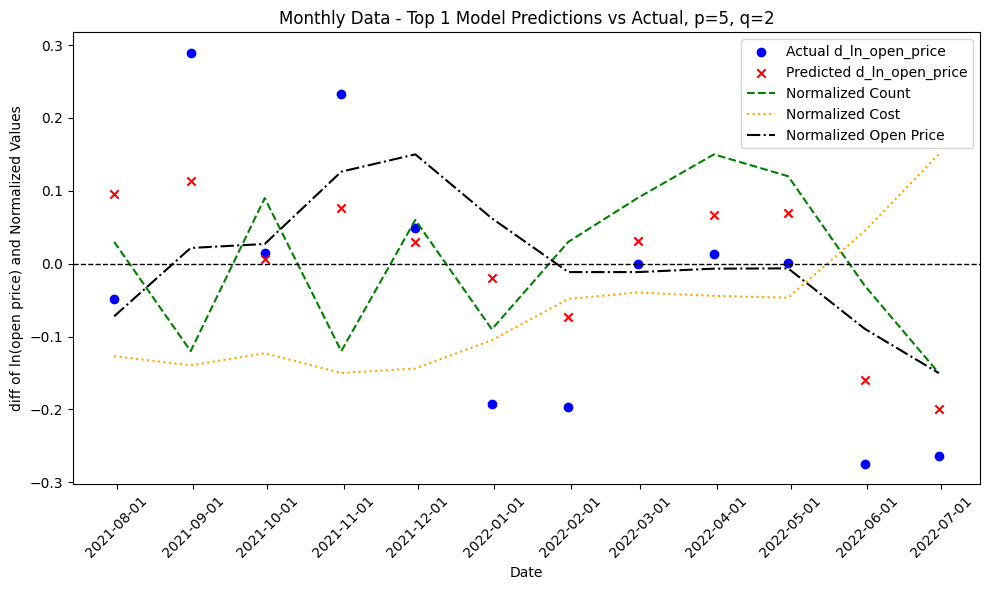

Top 2 Model: ARIMA(4,0,1), MAE: 0.08250778777962083
{'MSE': 0.01204198073506902, 'RMSE': 0.10973595917049717, 'AIC': -68.13290113364043, 'BIC': -46.922521693434106, 'Ljung-Box': 0.9995219513416177, 'Durbin-Watson': 1.9171683945624511, 'Jarque-Bera': 0.005671583697332182, 'Shapiro-Wilk': 0.039413828402757645, 'White Test': 0.001821485459202138}


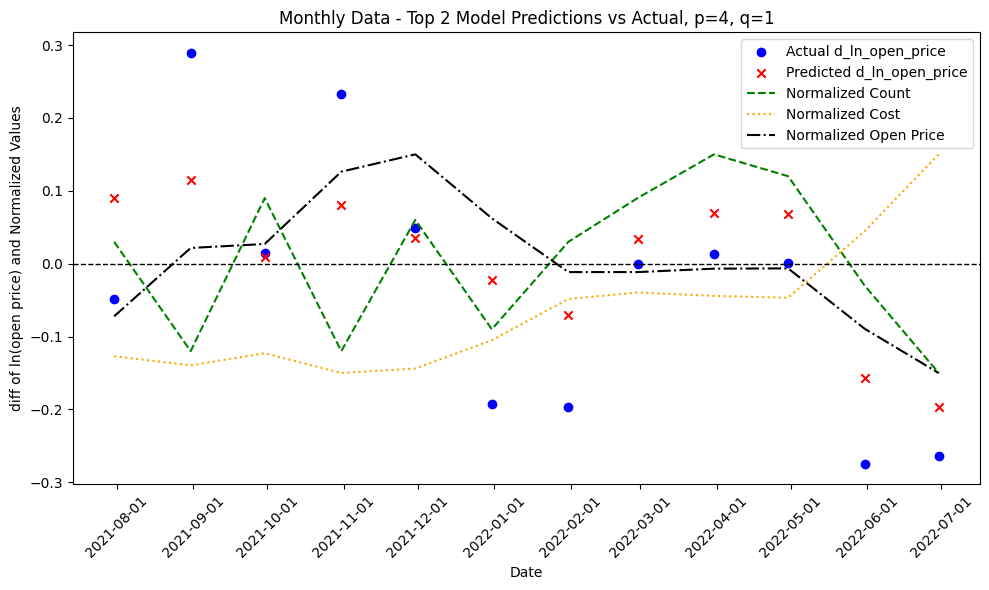

Top 3 Model: ARIMA(5,0,1), MAE: 0.08279830787290549
{'MSE': 0.012008872800579341, 'RMSE': 0.10958500262617756, 'AIC': -66.12981695138679, 'BIC': -42.56272868449087, 'Ljung-Box': 0.9995153688646771, 'Durbin-Watson': 1.91907771222345, 'Jarque-Bera': 0.005667473498172417, 'Shapiro-Wilk': 0.039568521082401276, 'White Test': 0.0018080578110974755}


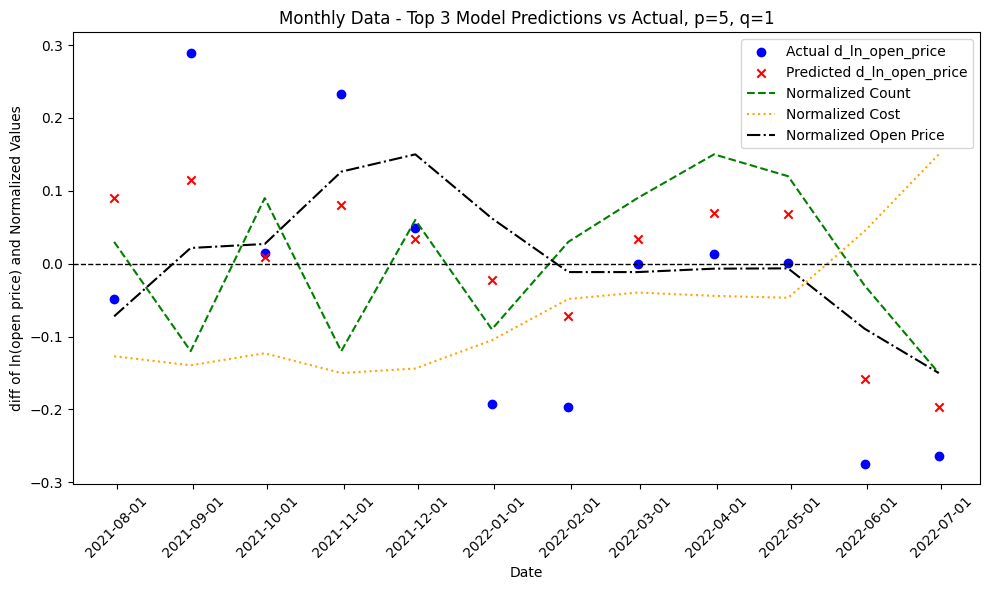

In [46]:
print("Monthly Data Model Estimation:")
model_estimation(monthly_data, range(1, 6, 1), range(1, 6, 1), title='Monthly Data', eval_size=12)
results_df

Distribution Plot:


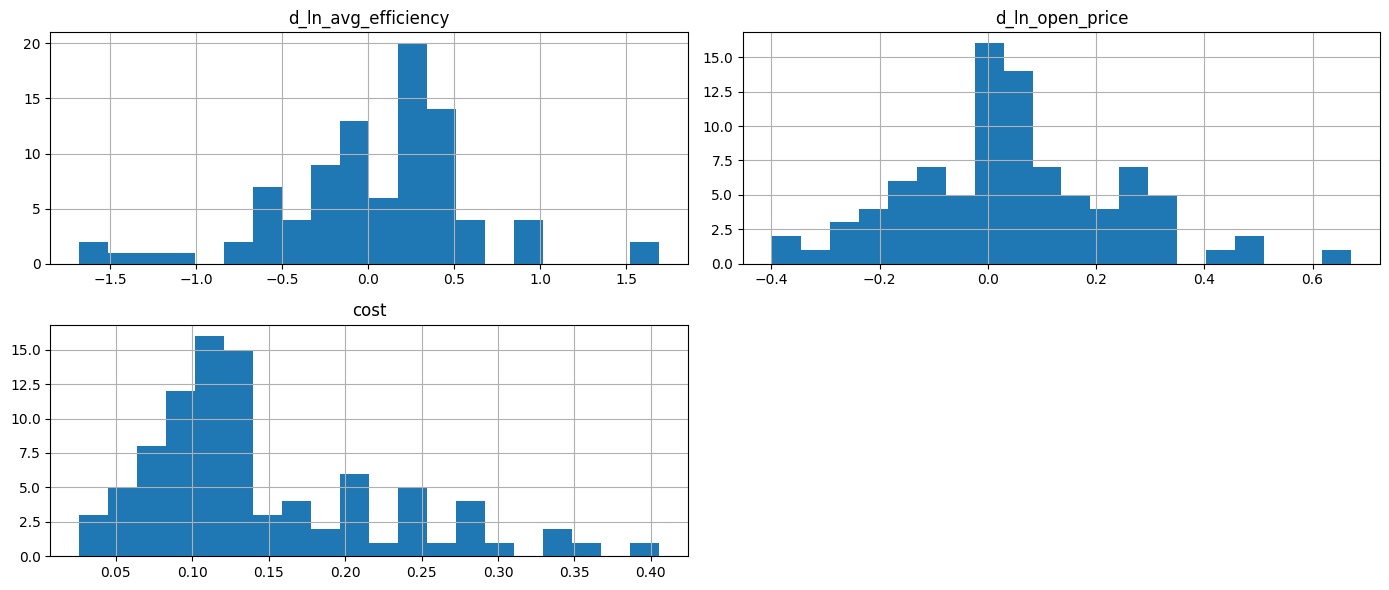

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


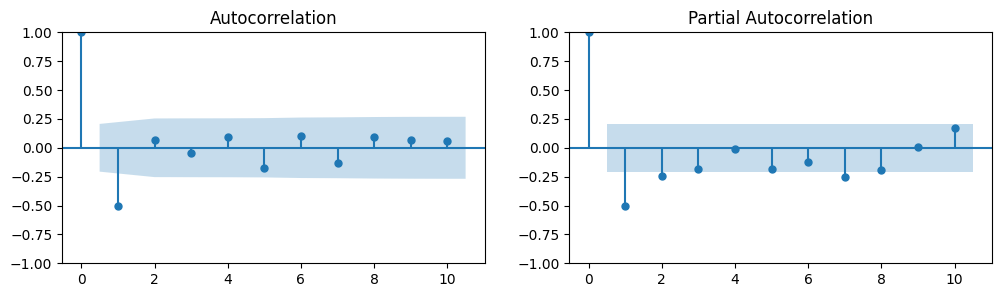

ACF and PACF Plots for d_ln_open_price:


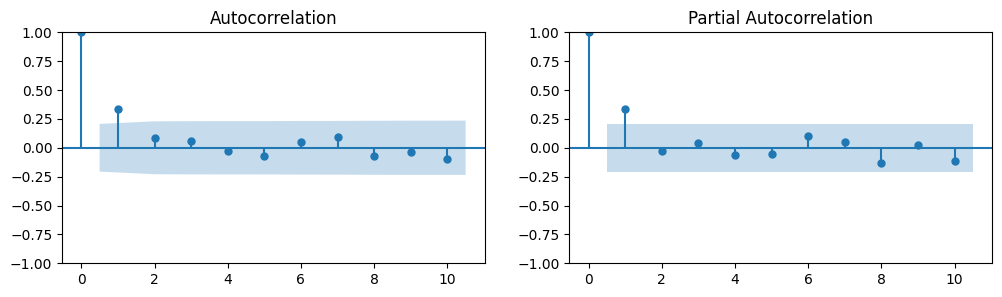

ACF and PACF Plots for cost:


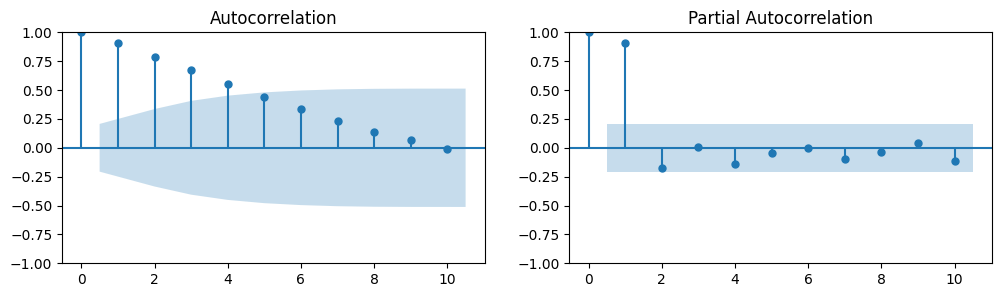

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_avg_efficiency,90.0,0.030605,0.572840,-1.679328,-0.301998,0.101139,0.358536,1.687166,-0.402647,1.825263
d_ln_open_price,90.0,0.049632,0.195528,-0.398711,-0.076752,0.038823,0.165967,0.671034,0.321875,0.496832
cost,90.0,0.145512,0.079120,0.026135,0.090696,0.121881,0.185888,0.405002,1.192189,0.998376


In [47]:
exploratory_analysis(monthly_data)

# Weekly

Weekly Data Model Estimation:
p: 1, q: 1, end: 337
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                  337
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 406.458
Date:                Sun, 24 Mar 2024   AIC                           -800.915
Time:                        21:06:44   BIC                           -777.995
Sample:                    01-04-2015   HQIC                          -791.780
                         - 06-13-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0183      0.011      1.701      0.089      -0.003       0.039
cost          -0.0304      0.070     -0.434      0.664      -0.167       0.107
d

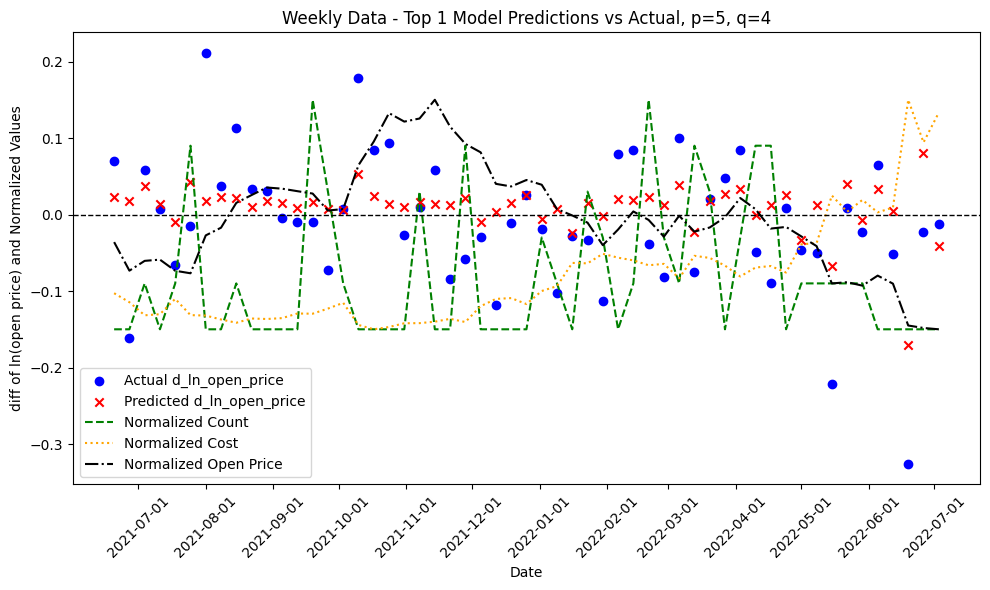

Top 2 Model: ARIMA(1,0,1), MAE: 0.055953609856295015
{'MSE': 0.005385478358421678, 'RMSE': 0.07338581851026585, 'AIC': -800.9154850919035, 'BIC': -777.9949875097893, 'Ljung-Box': 0.8346716926191412, 'Durbin-Watson': 1.9956984911934015, 'Jarque-Bera': 0.20510963509293573, 'Shapiro-Wilk': 0.040300674736499786, 'White Test': 4.17042916676259e-06}


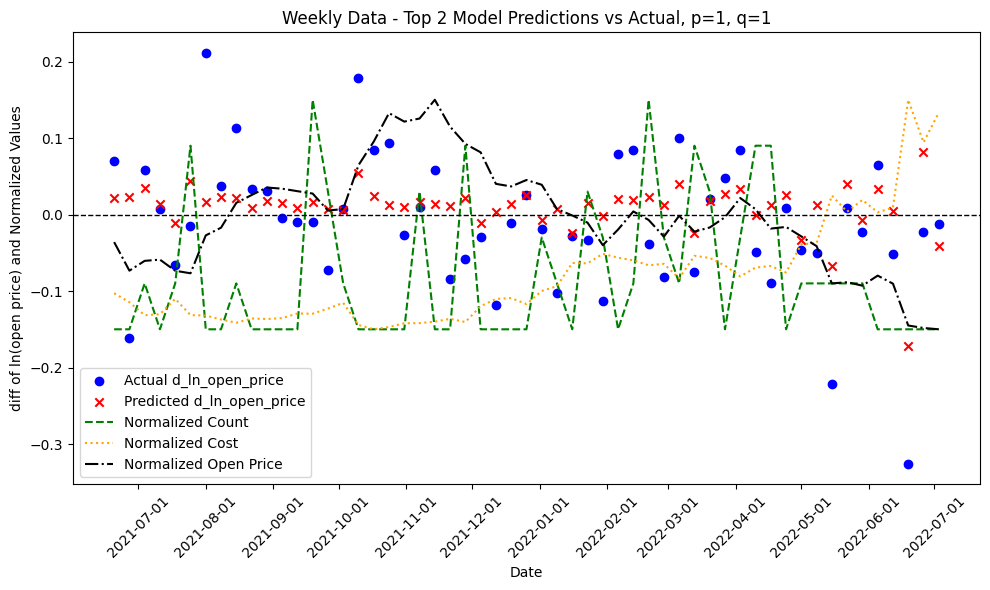

Top 3 Model: ARIMA(4,0,3), MAE: 0.05620897117237801
{'MSE': 0.005357584621767108, 'RMSE': 0.07319552323583121, 'AIC': -791.5925556801385, 'BIC': -749.5716434462626, 'Ljung-Box': 0.8333057397375769, 'Durbin-Watson': 1.995315845456868, 'Jarque-Bera': 0.20708835350960375, 'Shapiro-Wilk': 0.029607955366373062, 'White Test': 2.3527110865059727e-06}


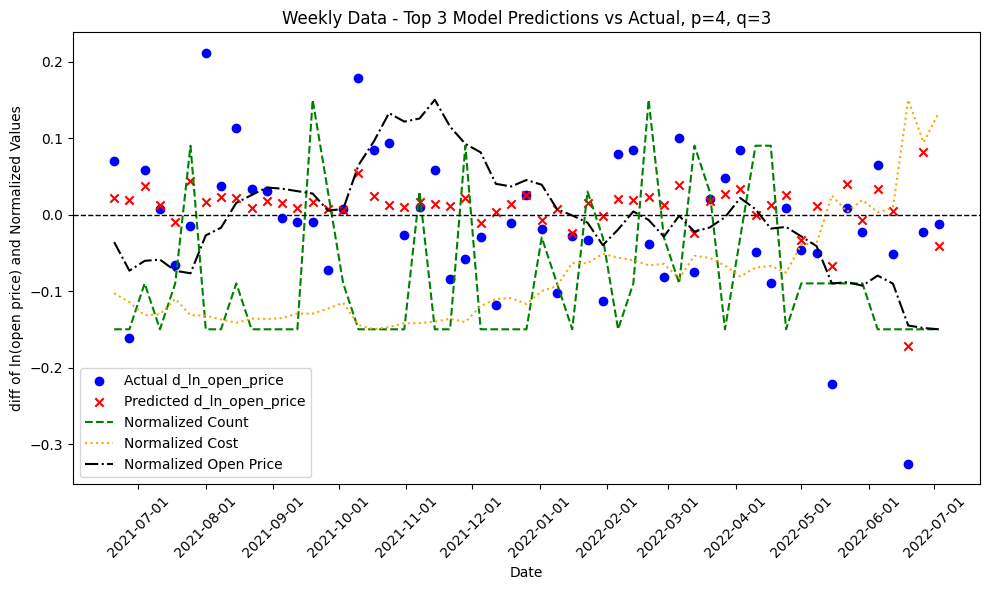

In [50]:
print("Weekly Data Model Estimation:")
model_estimation(weekly_data, range(1, 6, 1), range(1, 6, 1), title='Weekly Data', eval_size=55)
# model_estimation(weekly_data, range(1, 4, 1), range(1, 3, 1), title='Weekly Data', ratio=0.8)
results_df

In [ ]:
exploratory_analysis(weekly_data)

# Daily

In [ ]:
print("Daily Data Model Estimation:")
# model_estimation(daily_data, range(1, 6, 1), range(1, 6, 1), title='Daily Data', ratio=0.8)
model_estimation(daily_data, range(1, 3, 1), range(1, 3, 1), title='Daily Data', ratio=0.8)

In [ ]:
exploratory_analysis(daily_data)